# Malaria Cell Images Classification

Our project targets to develop a detection and classification system to accurately detect malaria disease present in images of thin blood smears. To do so we have used different malaria cell images some of ehich are parasitez and some uninfected and we created a convolutional neural network using tensorflow and keras which is able to classify weteher the cells are infected or not. 

This is very a very important problem nowadays as the detection of malaria is slow and most of the most infected countries do not have the necessary resources to properly detect it so our aim is to help with this issue and try to find a way which makes the process easier and quicker an which is as accurate as possible.

# Basic libraries

These are the necessary libraries to run our code.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf

# -------------------------------------------------------------------------------------------
# If you are using local GPUs:
# insert this piece of code after importing tf to solve the following CUDA error
# "Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed
# to initialize, so try looking to see if a warning log message was printed above.
# [[{{node conv2d/Conv2D}}]]"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
# -------------------------------------------------------------------------------------------

# -----------------------------------------------------------------------
# If you want to use your CPUs only
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
# -----------------------------------------------------------------------

from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os

# to make the output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

# Libraries

In [3]:
import cv2
import os
import shutil
import random
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout, Activation, Flatten, Conv2D, MaxPooling2D


### GPU

In [4]:
# Check that TensorFlow has detected my GPU
print('GPU device: ', tf.test.gpu_device_name())

GPU device:  


In [5]:
! nvidia-smi

/bin/bash: nvidia-smi: command not found


We will first import our data using cv2 as it will import all our different images and show an example of an infected cell

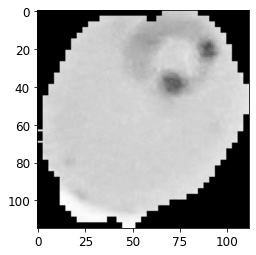

In [6]:
import cv2
datadir = '/Users/mac/Desktop/3rd/AI MACHINE LEARNING/project/cell_images'
categories = ["infected","healthy"]

for category in categories:
    path=os.path.join(datadir,category)
    for img in os.listdir(path):
        #convert to grey scale to recude size of data as it is not important for our data
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array,cmap="gray")
        plt.show()
        break
    break   #show an image

Lets check the image shape and normalize it to do the model later on

In [7]:
print(img_array.shape)

(115, 112)


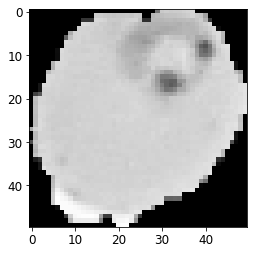

In [8]:
#normalize sizes of images so they are all the same and reduce definition to make it easier for the model
img_size = 50

new_array=cv2.resize(img_array,(img_size,img_size))
plt.imshow(new_array,cmap='gray')
plt.show()

We will now separate the data into training set to train our model for future classification of parasitized and uninfected cells.

In [9]:
# create trainig data
training_data = []

def create_trainig_data():
    for category in categories:
        path=os.path.join(datadir,category)
        class_num=categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array=cv2.resize(img_array,(img_size,img_size))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
            
create_trainig_data()

            
            

Check the length

In [10]:
print(len(training_data))

27558


In [11]:
import random
#shuffle our data to improve the learning of the model
random.shuffle(training_data)
#check if its shuffled
for sample in training_data[:10]:
    print(sample[1])

1
1
1
0
1
0
1
1
0
0


In [12]:
X = []
y = []

In [13]:
for features, label in training_data:
    X.append(features)
    y.append(label)
    
#convert x to numpy array and reshape in order to use keras 
X = np.array(X).reshape(-1,img_size,img_size,1)    

In [14]:
len(y)

27558

In [15]:
y[22]

1

Lets plot a series of cells to get an idea of how parasitized and uninfected cells look like and in what they differ from each other.

(-0.5, 49.5, 49.5, -0.5)

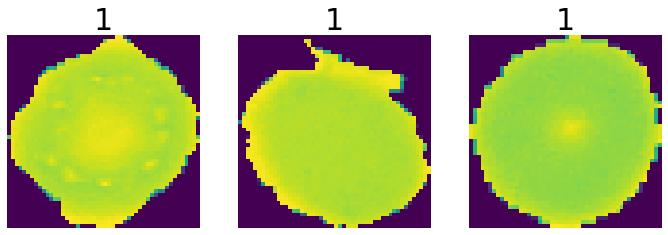

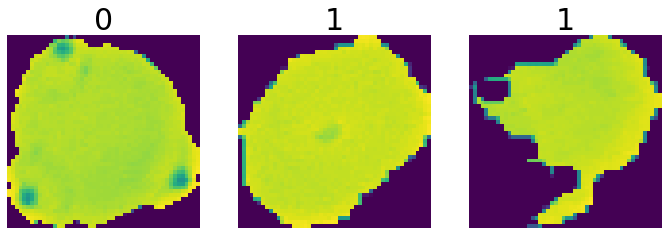

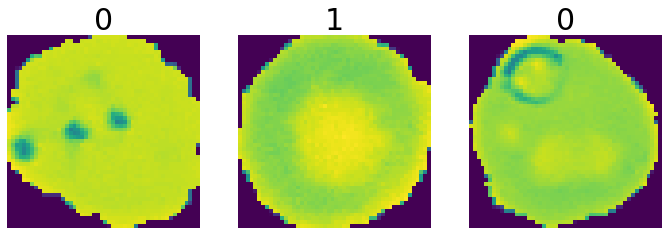

In [17]:
## 0
plt.figure(figsize = (20,20))
plt.subplot(1,5,1)
plt.imshow(X[0]) # image 1
plt.title(y[0],fontsize=30)
plt.axis("off")
plt.subplot(1,5,2) # image 2
plt.imshow(X[6])
plt.title(y[6],fontsize=30)
plt.axis("off")
plt.subplot(1,5,3) #image 3
plt.imshow(X[10])
plt.title(y[10],fontsize=30)
plt.axis("off")

plt.figure(figsize = (20,20))
plt.subplot(1,5,1)
plt.imshow(X[30]) # image 1
plt.title(y[30],fontsize=30)
plt.axis("off")
plt.subplot(1,5,2) # image 2
plt.imshow(X[17])
plt.title(y[17],fontsize=30)
plt.axis("off")
plt.subplot(1,5,3) #image 3
plt.imshow(X[22])
plt.title(y[22],fontsize=30)
plt.axis("off")

plt.figure(figsize = (20,20))
plt.subplot(1,5,1)
plt.imshow(X[31]) # image 1
plt.title(y[31],fontsize=30)
plt.axis("off")
plt.subplot(1,5,2) # image 2
plt.imshow(X[32])
plt.title(y[32],fontsize=30)
plt.axis("off")
plt.subplot(1,5,3) #image 3
plt.imshow(X[43])
plt.title(y[43],fontsize=30)
plt.axis("off")

From the pictures we learn that infected cells contain some stains or smears, unlike the healthy that seem homogenic and clean.

In [18]:
import pickle
#to save data so we don't have to re-do it everytime
pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [19]:
#to re-open the data
pickle_in = open("X.pickle","rb")
X=pickle.load(pickle_in)

In [20]:
# i used sklearn modul for splitting process
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [21]:
len(X_test)

5512

In [22]:
#normalize data to feed it through neural network
X = X/255
y=np.array(y)#in order to fit the model, if not it gave error

model = Sequential()
model.add(Conv2D(64,(3,3),input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3))) 
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
          
model.add(Flatten())
model.add(Dense(64))
          
model.add(Dense(1))
model.add(Activation('sigmoid'))
          
model.compile(loss="binary_crossentropy", #as we only have 2 options lets use binary
            optimizer="adam",
            metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.1) #validation data of 10%

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

## Evaluation 
Moving on to evaluating the model we are gonna look at three different things.   
- Firstly the learning curve and accuracy curve, to assess the fit of our model.   
- Then, to go a bit further, we are gonna get the classification matrix and look at the errors made. 

>Code to plot both Learning Rate plot and Accuracy vs Epochs

In [ ]:
import matplotlib.pyplot as plt
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

**1st - Learning Curve**   
We are going to plot both: 
-	Train Learning Curve: calculated from the training dataset that gives an idea of how well the model is learning.
-	Validation Learning Curve: calculated from the hold-out validation dataset that gives an idea of how well the model is generalizing.


We can observe that…
- The plot of training loss continues to decrease with experience 
- The plot of validation loss decreases to a point and begins increasing again.  
These two facts indicate that the model might be overfitting the data, since there is this disparity from the who lines as the learning times increases. Perhaps the best is to not continue to train to 30 epochs. 


**2nd - Accuracy Plot**  

Usually, in clinical disease classification experts strive for a high recall value, since the data consists of a high majority class of negatives and much fewer positive observations.  Therefore, the aim is to make sure that none of the positives are misclassified as negative, because in disease diagnosis this can have really severe implications, much worse that if a negative is identified as positive.  
However, in our case we happen to count with an extremely balanced target variable, where half of the cells are parasitized, and the other half are uninfected. Therefore, we can proceed to use accuracy as a good indicator of how well our model is classifying.  
Still, we can look at recall later to assess whether one class or the other are being better recognized. 


>Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
# Calculate errors and confusion matrix for the validation data
Y_pred_probabilities = model.predict(X_test)
Y_pred = np.round(Y_pred_probabilities)

errors = []
for i in range(len(Y_pred)):
    if Y_pred[i] != y_test[i]:
        errors.append([i, Y_pred_probabilities[i][0]])
sorted_errors = sorted(errors, key=lambda rec: rec[1], reverse=True)

print(confusion_matrix(y_test, Y_pred))
print("\nNumber of errors = ", len(sorted_errors))
print("Accuracy = ", (len(y_test) - len(sorted_errors)) / float(len(y_test)))

Going to the classification matrix we can assess more specifically weather the model had more trouble classifying a certain class or not.  
And as we can see, the FN and FP are pretty much the same, therefore their recall is the same too. 

## Beyond...Show Errors

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred))

In [ ]:
def display_errors(errors_index):
    """Show images with their predicted and real labels."""
    n = 0
    nrows = 4
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(10,10))
    for row in range(nrows):
        for col in range(ncols):
            index = errors_index[n][0]
            pred = errors_index[n][1]
            img = X_test[index]
            ax[row, col].imshow(img)
            ax[row, col].set_title("True:{} Pred:{:1.3f}".format(y_test[index], pred)                                                 )
            n += 1

In [ ]:
# show mispredictions
display_errors(sorted_errors[0:])

In [ ]:
#show more mispredictions
display_errors(sorted_errors[-20:])

Now, out of curiosity, we wanted to explore the errors. 
So, here we have a sample of some of the False Positives committed by the model. All of this cells are in reality Parasitized, however, we see how some do look at first glance like they are infected indeed (from what we’ve seen earlier) and others, despite being parasitized you wouldn’t tell so from how clean there appearance is. 
We get the same for the uninfected cells. 

#### Considerations regarding errors commited

So firstly, examining the errors like this made us question to what extent is the data reliable, for who can believe that this cells over here are healthy and don’t have a disease right? On this note, this are considerations for future studies, where data quality should definitely be evaluated thoroughly.   
Aside from this, it is necessary to mention that the problematic side is the false positives rather than the negatives. Keeping in mind that a positive means Uninfected, well false positive means malaria was not detected when it was there actually and for future improvements of this model that should be the objective, to reduce specifically that error. 
